# milestone-II-stock-predictions
This code is being produced to fulfil the requirements of the Milestone 2 project in the University of Michigan Masters in Applied Data Science degree.

This Milestone project will build on the Milestone 1 Project. The goal of this project will be to study stock market data and predict future returns. We will extend the data, data manipulation processes and feature generation approach from that project to create the dataset for this project. We will also explore unsupervised learning to attempt to get a better understanding of the categories of stocks included in this project, and their changes over time. One output of the unsupervised learning we conduct will be to contribute additional features to the supervised learning approach. Our dataset will include approximately 250-300 UK stocks over approximately five years from 2016 to 2021.

## supervised learning
The input data consists of 3 types of features. They are 1) stock price histories including amount traded per day (volume), 2) fundamental data about the company such as revenue, earnings per share, and 3) technical features derived from price histories and volume. Many of these are Finance-domain specific but others are more widely applicable across domains. In total there are over 1000 features. This notebook focuses on supervised learning approaches to this problem. Through analysis with this dataset we have found that model performance using all or most of the features did not generalize well to the test set. Therefore I focused on a recursive feature selection approach to select a subset of features that would perform better on both the train and test sets. This recursive feature selection approach is coded bespoke. It allows the possibility to add or remove a feature from the current best set. If the result is better with the new featureset that becomes the new best featureset. Since predicting future stock market returns is a time-series problem we have kept two validation data sets, one is concurrent with the test set and another will be for a time period after the test set. In this notebook and the recursive feature selection we experimented with many different models and found that the best results by quite a margin were achieved with Random Forest models. We predominantly intend to treat this as a regression problem attempting to predict the percentage price change from the date of the featureset to the date of the future price. However, the notebook is setup with the option to treat this as a classification problem instead. In that case, we would be predicting whether the stock will go up over the next 20 trading days.

The dataset contains daily stock information for a set of 253 UK stocks covering dates from January 2017 to September 2021. If an approach like this was used to inform trading decisions, it would make sense to focus only on the stocks that are predicted to go up the most. If this is run as a classification problem then it would make sense to focus on stocks that are predicted to have the highest probability of going up. In either case an appropriate evaluation metric is precision. Just as in trading, we don't have to trade every stock but can focus on the stocks we think are worth trading, so with precision we can evaluate only on stocks we think will be the best performers over the 20 trading day time horizon selected. We will do evaluation in 2 ways, firstly, precision for stocks that are predicted to go up and precision for the top x% of predictions. I would hope and expect that the top x% of predictions will achieve a higher precision than the precision for all stocks predicted to go up. Of course in trading a key consideration isn't just whether stocks go up but how much they go up or down. Our second approach to evaluation will be to measure the average return of all stocks that are predicted to go up. We will also measure the average return of the top x% of stocks. Again we would hope and aim to see the average return for the top x% of stocks being higher than the average return of all stocks predicted to go up.

As a naive benchmark we will calculate precision and average return in the case that we simply and unrealistically predict that all stocks will go up every day. Since the signal to noise ratio in Finance is low, this benchmark may not be trivial to outperform.

## unsupervised learning
This project will also incorporate some analysis through unsupervised learning. Most of that will be done in a separate notebook. However, in this notebook and the associated utilities file we run pca to add to the set of features that is considered during the recursive feature selection approach.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet, Ridge, Lasso, LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, precision_score
from matplotlib import pyplot as plt
from tqdm import tqdm
import copy

from utils_milestone2 import get_numeric_non_infinite_cols, add_pca_cols, scale_train_test, pca_train_test, run_model, \
feature_engineering, threshold_precision, full_and_threshold_scoring, pred_to_clf_pred, load_data, \
generate_benchmark_scores, return_results

### Parameters

In [2]:
Run_Feature_Selection = False
model_type="regression"

### Load the Data

In [3]:
%%time
X_train, y_train, X_test, y_test, X_val = load_data()

Wall time: 2.18 s


In [4]:
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (221122, 1105)
y_train shape (221122,)
X_test shape (32257, 1105)
y_test shape (32257,)


### Data Preprocessing
Check there are no nulls

In [5]:
is_NaN = X_train.isnull()
col_has_NaN = is_NaN.any(axis=0)
col_has_NaN = col_has_NaN.loc[col_has_NaN==True].index.to_list()
col_has_NaN

[]

Identify numeric columns

In [6]:
X_train_numeric = X_train._get_numeric_data()

Drop columns that contain infinity or negative infinity

In [7]:
col_has_inf = X_train_numeric.columns.to_series()[np.isinf(X_train_numeric).any()].to_list()
print(col_has_inf)
X_train_numeric = X_train_numeric.drop(col_has_inf, axis=1)
cols = X_train_numeric.columns.to_list()
X_test_numeric = X_test[cols]

['volume_adi', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg']


Classify train examples as 1 if the price went up otherwise 0.

In [8]:
y_train_clf = pred_to_clf_pred(y_train, threshold=1)
y_test_clf = pred_to_clf_pred(y_test, threshold=1)

Create a naive benchmark where everything is predicted to go up.

In [9]:
y_all_up_train = [1] * len(y_train_clf)
y_all_up_test = [1] * len(y_test_clf)

### Calculate Benchmark Scores

In [10]:
benchmark_scores = generate_benchmark_scores(y_train, y_test, y_train_clf, y_all_up_train, y_test_clf, y_all_up_test)

In [11]:
print("Benchmark figures over 20 day prediction horizon:")
benchmark_scores

Benchmark figures over 20 day prediction horizon:


{'train_precision': 0.5381,
 'test_precision': 0.5835,
 'train_return': 0.005,
 'test_return': 0.0221}

This is the benchmark precision if we predict everything goes up. Now we will test the precision of our model. We can see that market conditions in the test period were noticeably different to the training period as stocks were going up a lot more frequently over 20 day trading horizons.

### Engineering Features
Given the large number of features already generated and retrieved, it is not clear how much feature engineering will add. However, we will at least generate features that demonstrate when volume is above average as in the financial domain, price moves are widely thought to be more meaningful and likely to continue when accompanied by heavy volume.

In [12]:
X_train_numeric = feature_engineering(X_train_numeric)
X_test_numeric = feature_engineering(X_test_numeric)

C:\Users\micha\mads\milestone-II-stock-predictions\utils_milestone2.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume_over_Volume_MA50'] = df['Volume'] / df['Volume_MA50']
C:\Users\micha\mads\milestone-II-stock-predictions\utils_milestone2.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume_over_Volume_MA200'] = df['Volume'] / df['Volume_MA200']
C:\Users\micha\mads\milestone-II-stock-predictions\utils_milestone2.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy 

### Optional Scaling and Normalization

In [13]:
%%time
X_train_numeric_scaled, X_test_numeric_scaled = scale_train_test(X_train_numeric, X_test_numeric)

Wall time: 5.55 s


In [14]:
%%time
X_train_pca, X_test_pca = pca_train_test(X_train_numeric_scaled, X_test_numeric_scaled, num_components=200, random_state=2021)

Total Explained 0.9992301541002819
Wall time: 19.2 s


In [15]:
%%time
X_train_numeric_plus_pca = add_pca_cols(X_train_numeric, X_train_pca)
X_test_numeric_plus_pca = add_pca_cols(X_test_numeric, X_test_pca)

Wall time: 1.09 s


### Feature Selection
We saw in the earlier notebook that modeling with just a few features achieved better results than using all 1000+ features. Here we will start with a tiny number of features and iteratively try adding (& later dropping) features to improve model performance.

In [16]:
cols = X_train_numeric_plus_pca.columns.to_list()#[::-1]

In [17]:
#selected_cols = ['SR', 'ROCE_TTM_pct', 'Price_to_FCF_TTM', 'MACDSIGNAL_55', 'trend_ema_slow', 'others_dlr', 'volume_cmf', 'DX_14', 'MINUS_DM_14', 'ROCR100_25', 'RSI_25', 'WILLR_25', 'MFI_90', 'APO_f13_s89', 'MACDEXT_macdsignal_f3_s8_sig55', 'volume_vpt', 'APO_f5_s89']
#selected_cols = ['ROCE_TTM_pct', 'Price_to_FCF_TTM', 'MACDSIGNAL_55', 'trend_ema_slow', 'others_dlr']
selected_cols = ['SR', 'Volume_MA50', 'Volume_MA200', 'ADOSC_f2_s89', 'AROONup_40', 'AROONdown_90', 'CCI_90', 'MACDHIST_34', 'PPO_f2_s3', 'PPO_f8_s13']

In [18]:
default_precision_test = 0
default_precision_train = 0
default_return_test = 0
default_return_train = 0

In [19]:
cols_to_search = copy.deepcopy(cols)
# cols_to_search = ['SR', 'ROCE_TTM_pct', 'Price_to_FCF_TTM', 'MACDSIGNAL_55', 'trend_ema_slow', 'others_dlr'] + ['Sector_Basic Materials',
#  'Sector_Consumer Cyclicals',
#  'Sector_Consumer Defensives',
#  'Sector_Energy',
#  'Sector_Financials',
#  'Sector_Healthcare',
#  'Sector_Industrials',
#  'Sector_Technology',
#  'Sector_Telecoms',
#  'Sector_Utilities']
# cols_to_search

In [20]:
%%time

loop_best = 0
if Run_Feature_Selection:
    for a in range(20): # later loops give a chance to drop features that were useful originally but are not useful with the latest best feature set   
        for c in tqdm(cols_to_search):
            current_selection = copy.deepcopy(selected_cols)
            if c in current_selection and len(current_selection) > 1:
                current_selection = [x for x in current_selection if x!=c]#.remove(c)
            else:
                current_selection.append(c)

            train_scores, test_scores, model = run_model(current_selection, X_train_numeric_plus_pca, X_test_numeric_plus_pca, y_train, y_test, model_type=model_type)

            if test_scores['default_return'] > default_return_test and train_scores['default_return'] > default_return_train:
                default_return_test = test_scores['default_return']
                default_return_train = train_scores['default_return']
                selected_cols = copy.deepcopy(current_selection)

        print("train return at default", default_return_train, "test return at default", default_return_test)
        print("##################################################################")
        print(selected_cols)

        if loop_best==default_return_test:
            print("early stopping no improvement")
            break
        loop_best=default_return_test

    

Wall time: 0 ns


### Final Model Run
With our selected features we can run the final model. Note this features were selected by the recursive feature selection technique above, but, that is not illustrated in this notebook because for random forest the recursive feature selection/elimination can take many hours to run.

In [21]:
train_scores, test_scores, model = run_model(selected_cols, X_train_numeric_plus_pca, X_test_numeric_plus_pca, y_train, y_test, model_type=model_type)

In [22]:
#print_benchmarks()
print("############################################################")
print("Number of selected features:", len(selected_cols), "from", len(X_train_numeric_plus_pca.columns), "available features")
print("############################################################")
print("Results Summary")
results = return_results(benchmark_scores, train_scores, test_scores)
results

############################################################
Number of selected features: 10 from 1302 available features
############################################################
Results Summary


,dataset,metric,benchmark,default,threshold
0,train,precision,0.5381,0.5501,0.6398
1,test,precision,0.5835,0.5899,0.673
2,train,return,0.50%,0.88%,8.64%
3,test,return,2.21%,2.51%,6.41%


Here we can see that with the selected features, which are a very small subset of the total available features, we have achieved precision and average return for our top 5% of predictions on train and test that is considerably better than the benchmark. Where we measure precision and average return on all stocks where the prediction was that the price would go up we have also beaten the benchmark.

Now let's take a look at the feature importances from our Random Forest Model.

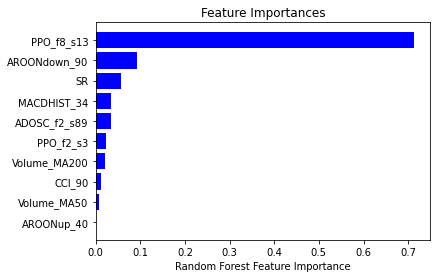

In [23]:
features=X_train_numeric_plus_pca[selected_cols].columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(1);
plt.title('Feature Importances');
plt.barh(range(len(indices)), importances[indices], color='b', align='center');
plt.yticks(range(len(indices)), features[indices]);
plt.xlabel('Random Forest Feature Importance');

### Next Steps
Possible clearer presentation of model results vs benchmark